In [1]:
data=read.table("data/zheng68k/zheng68k.csv",sep=",",header=T,row.names=1)

In [2]:
annotation=read.table("data/zheng68k/68k_pbmc_barcodes_annotation.tsv.txt",header=TRUE,sep="\t")



head(annotation)

,TSNE.1,TSNE.2,barcodes,celltype
,<dbl>,<dbl>,<chr>,<chr>
1,7.565540,0.4413703,AAACATACACCCAA-1,CD8+ Cytotoxic T
2,2.552626,-25.7866723,AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
3,-5.771831,11.8308460,AAACATACCGGAGA-1,CD4+/CD45RO+ Memory
4,1.762556,25.9793459,AAACATACTAACCG-1,CD19+ B
5,-16.793856,-16.5899699,AAACATACTCTTCA-1,CD4+/CD25 T Reg
6,-15.339791,-11.0882635,AAACATACTGGATC-1,CD4+/CD25 T Reg


In [3]:
extract_prediction_label = function(x){
    y=c()
    for (i in x){
        y=c(y,i)
    }
    y
    return(y)
}



calculate_test_accuracy <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  correct_predictions <- sum(true_labels == predicted_labels)
  total_samples <- length(true_labels)
  
  accuracy <- correct_predictions / total_samples
  return(accuracy)
}


calculate_f1_score_multiclass <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  # Get unique class labels
  classes <- unique(c(true_labels, predicted_labels))
  
  # Initialize variables to store per-class statistics
  precision <- numeric(length(classes))
  recall <- numeric(length(classes))
  f1_score <- numeric(length(classes))
  
  # Calculate precision, recall, and F1 score for each class
  for (i in 1:length(classes)) {
    class_label <- classes[i]
    true_positive <- sum(predicted_labels == class_label & true_labels == class_label)
    false_positive <- sum(predicted_labels == class_label & true_labels != class_label)
    false_negative <- sum(predicted_labels != class_label & true_labels == class_label)
    
    precision[i] <- true_positive / (true_positive + false_positive)
    recall[i] <- true_positive / (true_positive + false_negative)
    
    f1_score[i] <- 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
  }
  
  # Calculate macro-averaged F1 score
  macro_f1_score <- mean(f1_score, na.rm = TRUE)
  
  return(macro_f1_score)
}




Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

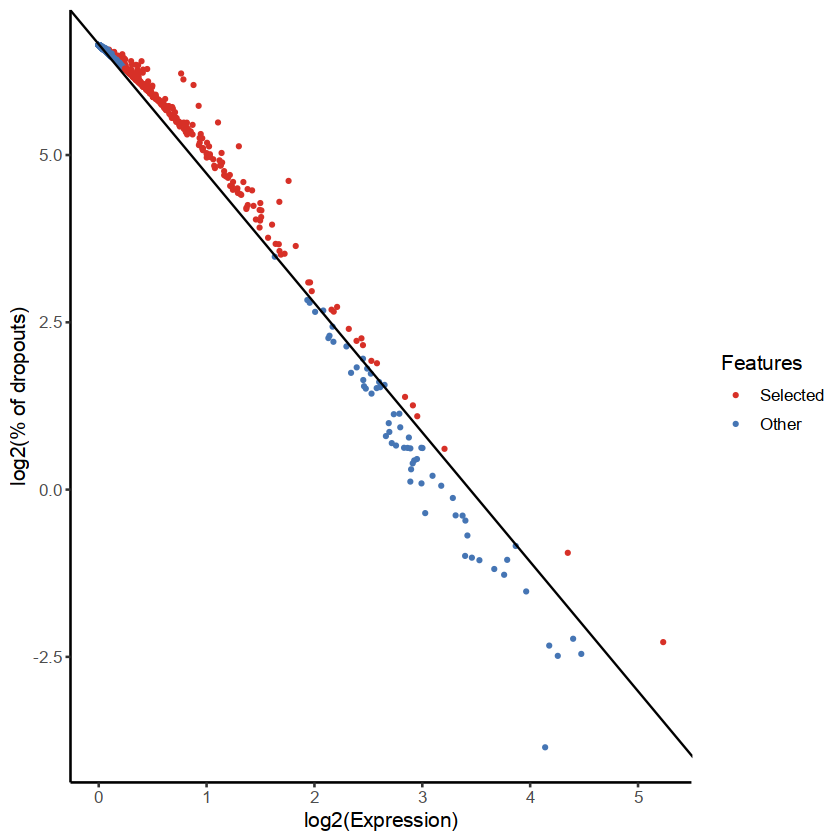

Fold 1 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.3928259 F1 score: 0.4201096 


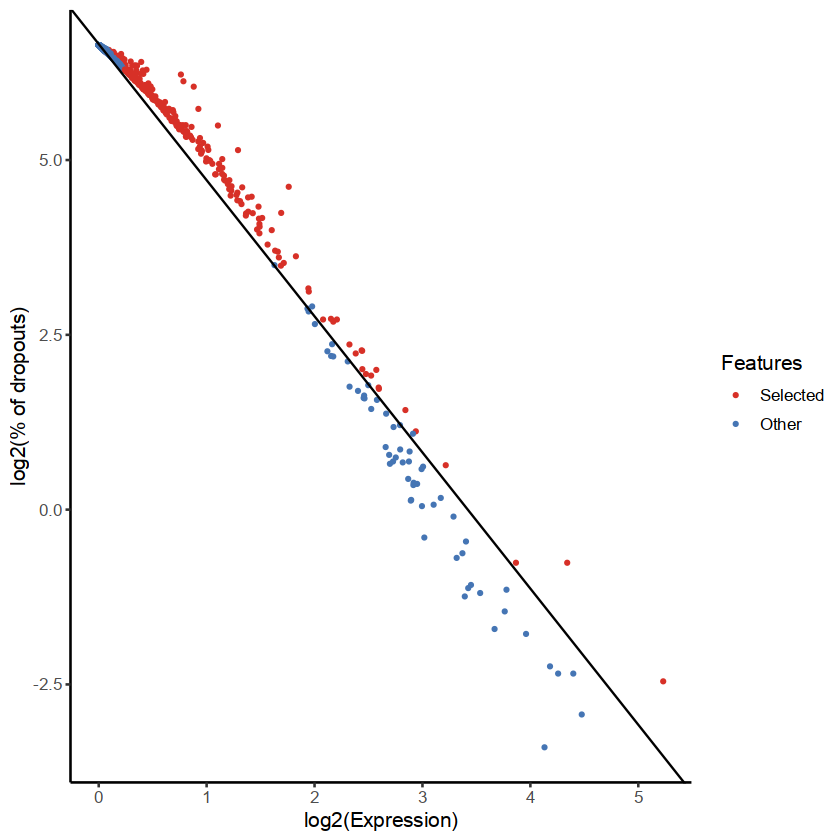

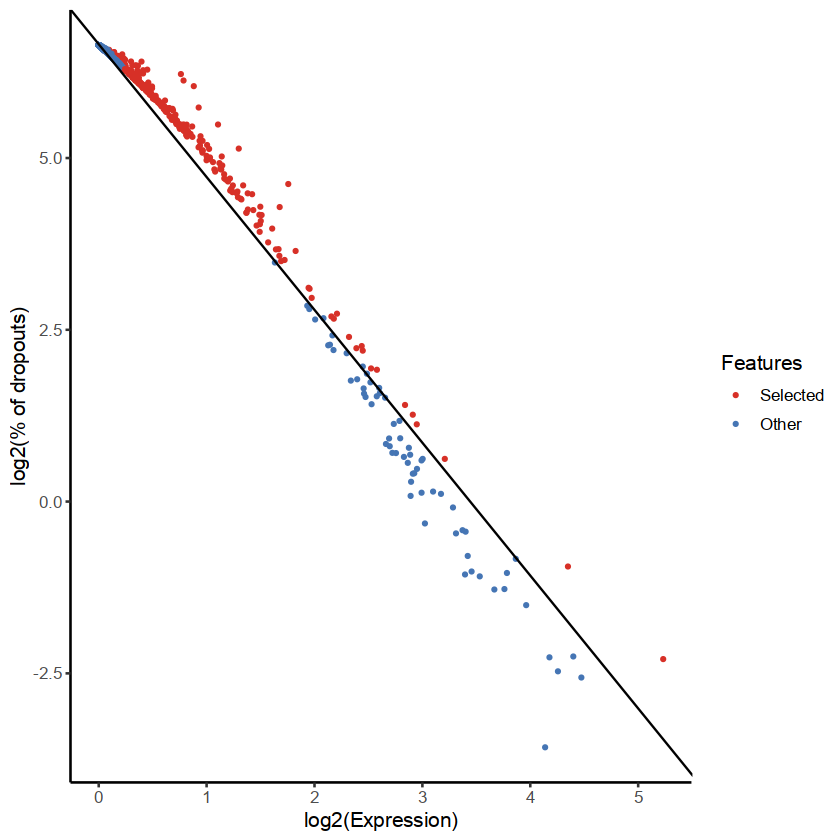

Fold 2 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.3960338 F1 score: 0.4173282 


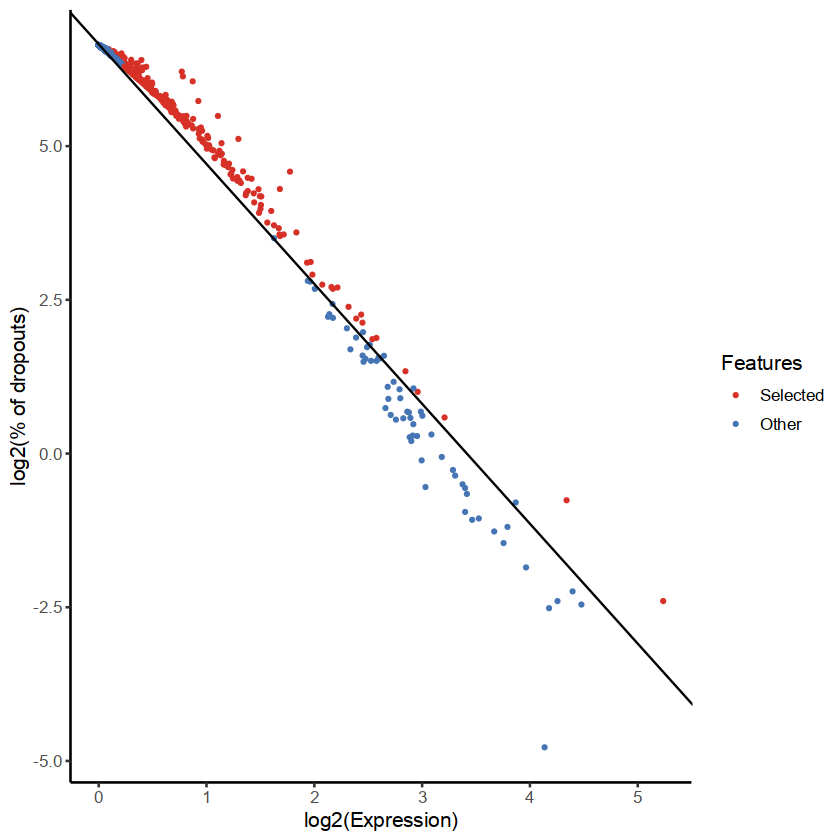

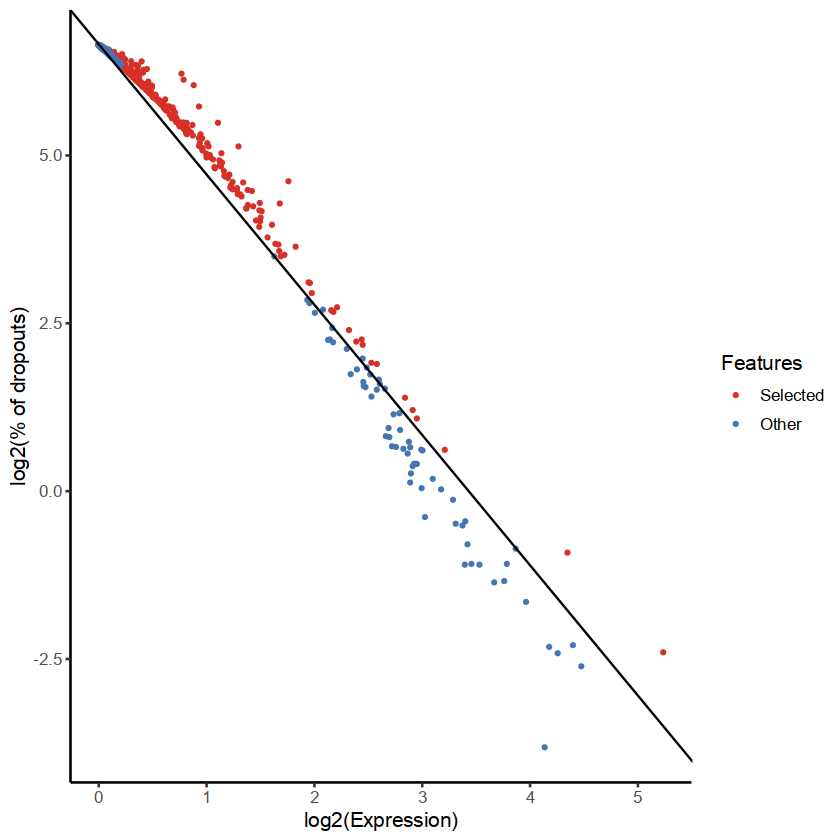

Fold 3 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.379338 F1 score: 0.4477993 


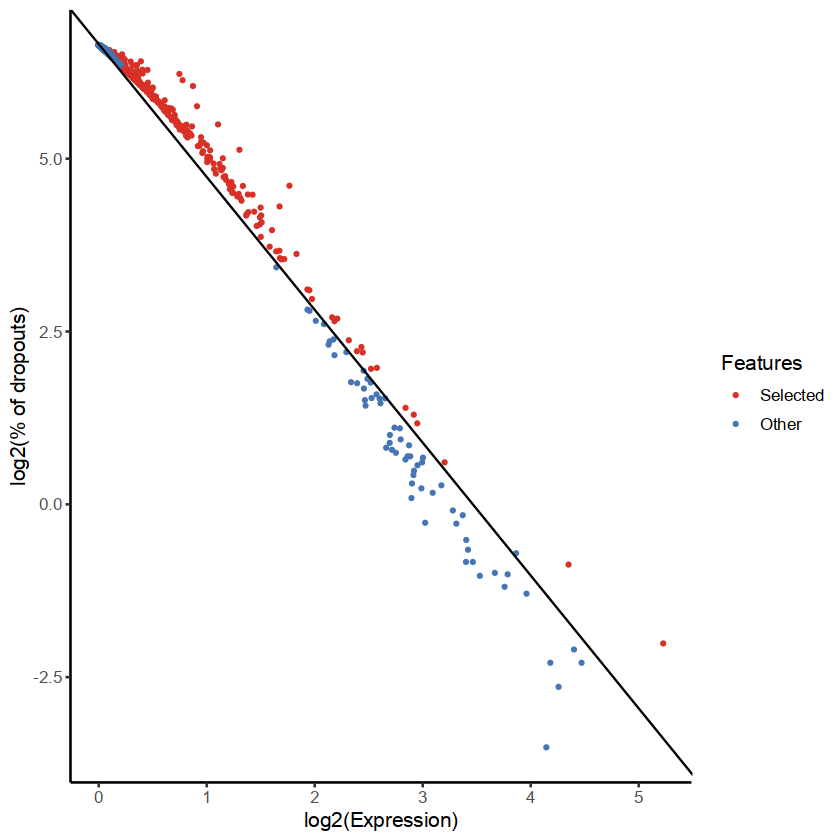

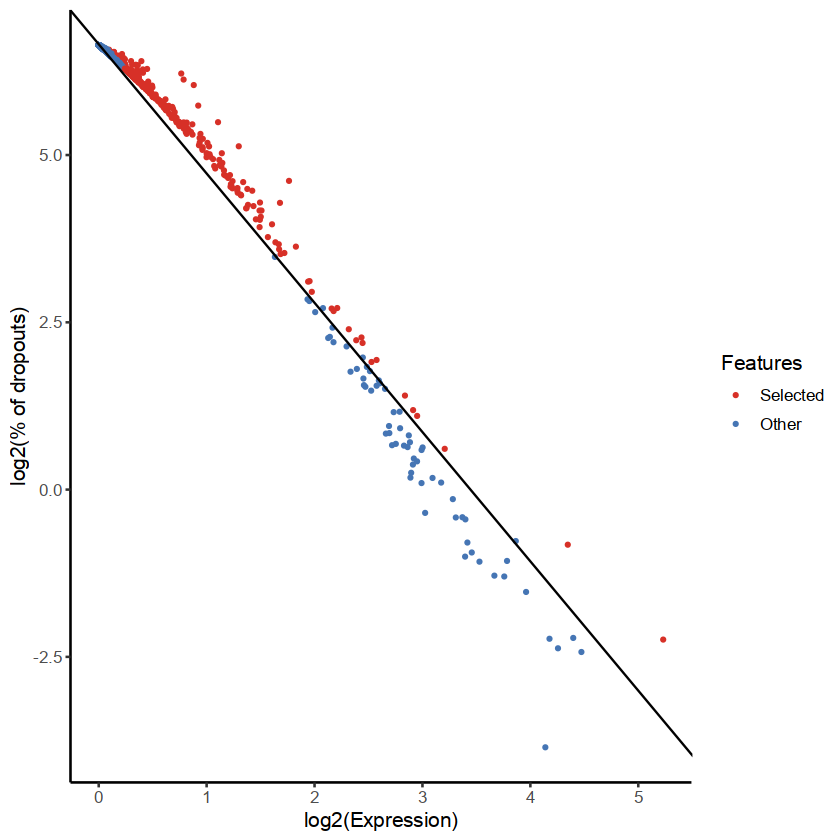

Fold 4 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.3780986 F1 score: 0.4107568 


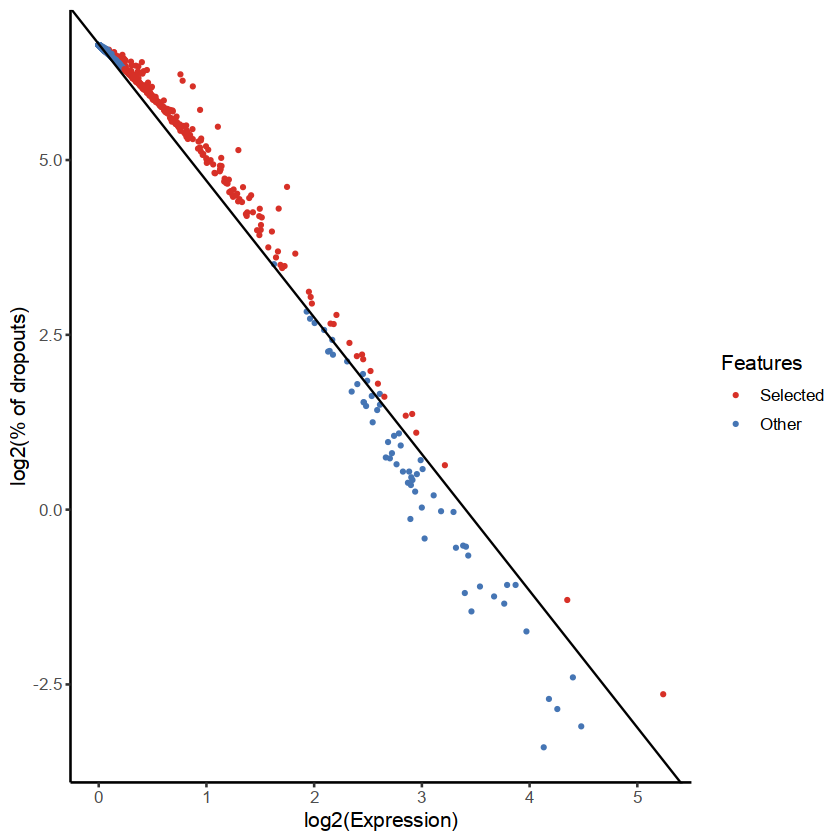

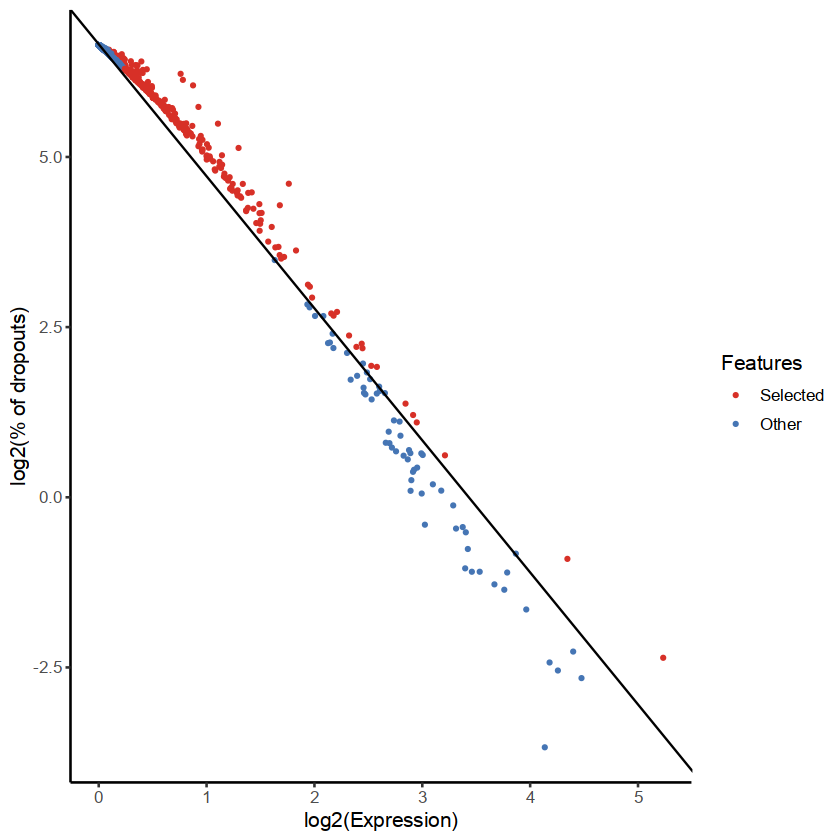

Fold 5 : Train samples = 54864 , Test samples = 13715 Accuracy: 0.3886256 F1 score: 0.4567077 


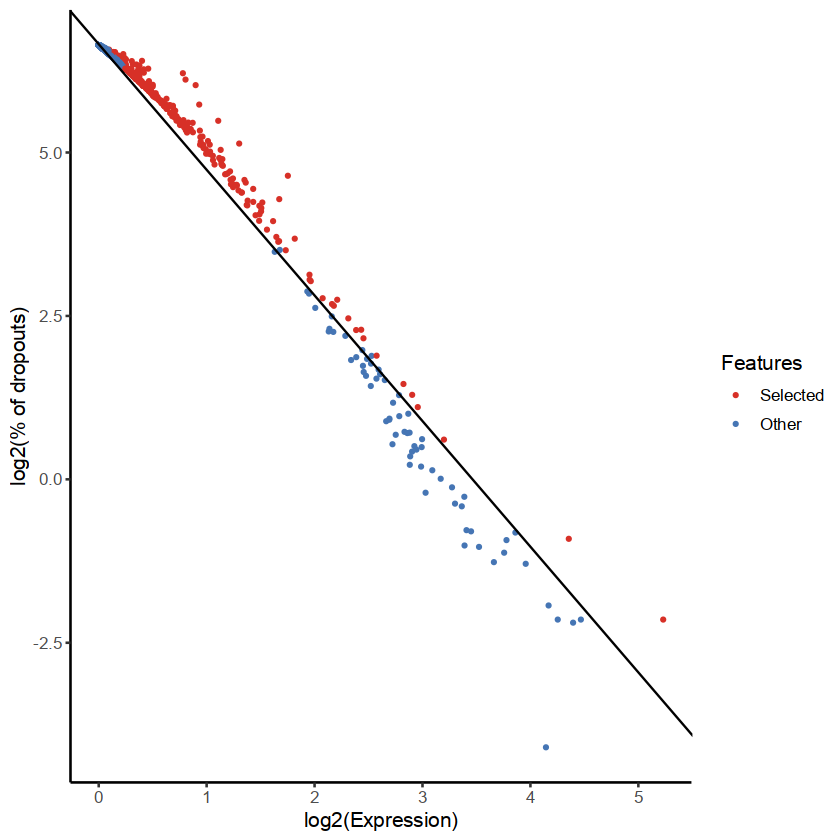

In [4]:
#scmapCluster

library(SingleCellExperiment)
library(scmap)

num_folds <- 5

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]

  anno_train$cell_type1=anno_train$celltype

  reference = SingleCellExperiment(assays = list(counts = t(data_train)),colData = anno_train["cell_type1"])

  logcounts(reference) <- log2(counts(reference) + 1)

  rowData(reference)$feature_symbol <- rownames(reference)
  
  reference <- selectFeatures(reference, suppress_plot = FALSE)

  reference <- indexCluster(reference)



  query = SingleCellExperiment(assays = list(counts = t(data_test)))

  logcounts(query) <- log2(counts(query) + 1)

  rowData(query)$feature_symbol <- rownames(query)

  query <- selectFeatures(query, suppress_plot = FALSE)

  #query <- indexCluster(query)



  scmapCluster_results <- scmapCluster(
  projection = query, 
  index_list = list(
    yan = metadata(reference)$scmap_cluster_index
    )
  )
  predictions=as.vector(scmapCluster_results$scmap_cluster_labs)

  acc = calculate_test_accuracy(predictions,anno_test$celltype)
  f1_score = calculate_f1_score_multiclass(predictions,anno_test$celltype)

  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "Accuracy:", acc,"F1 score:", f1_score, "\n")

}

Warning message in split.default(sample(nrow(data)), 1:num_folds):
“data length is not a multiple of split variable”
Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2743150)”


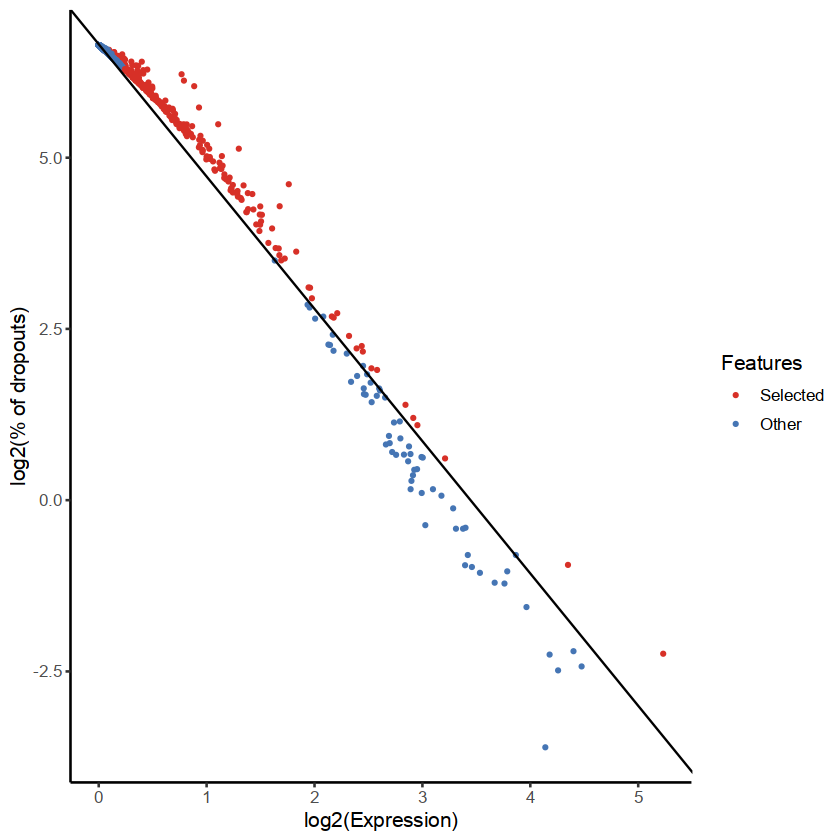

Fold 1 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.2434383 F1 score: 0.4161746 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2743150)”


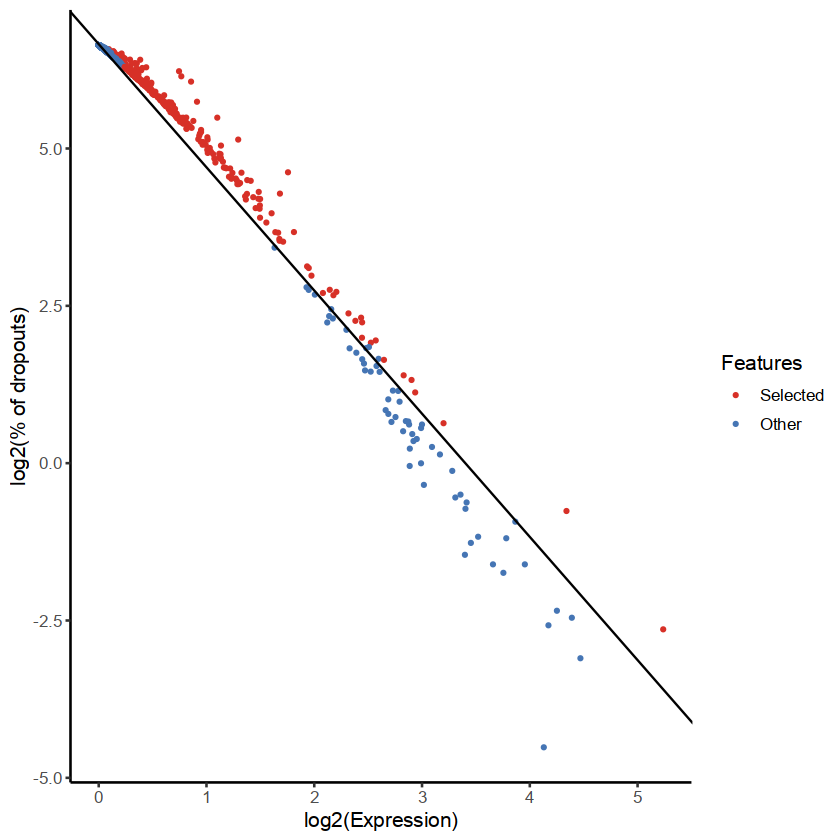

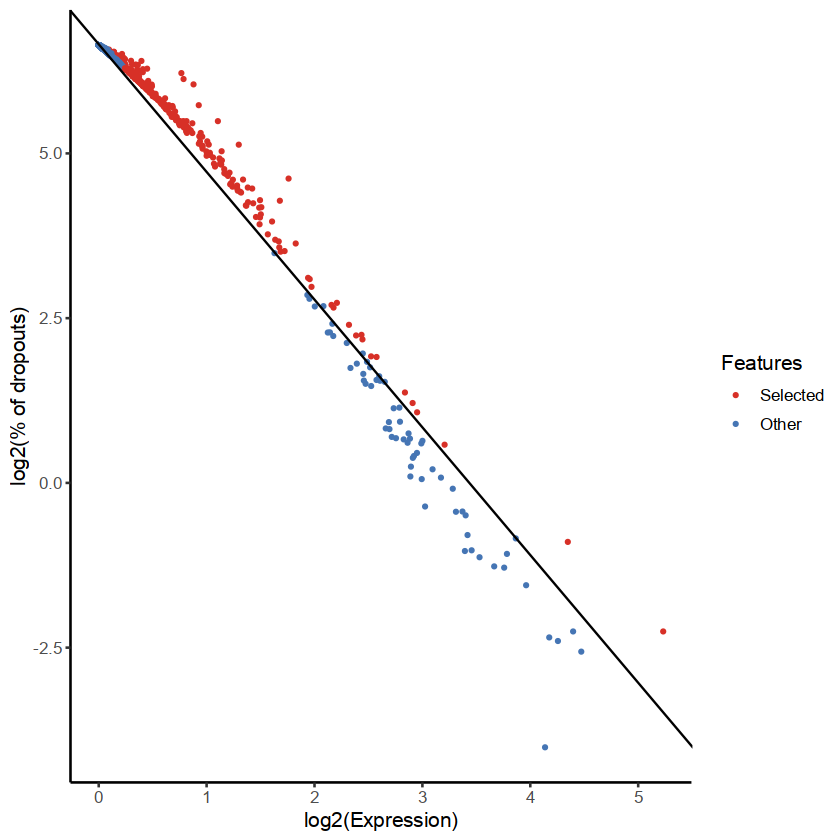

Fold 2 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.2483231 F1 score: 0.4130395 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



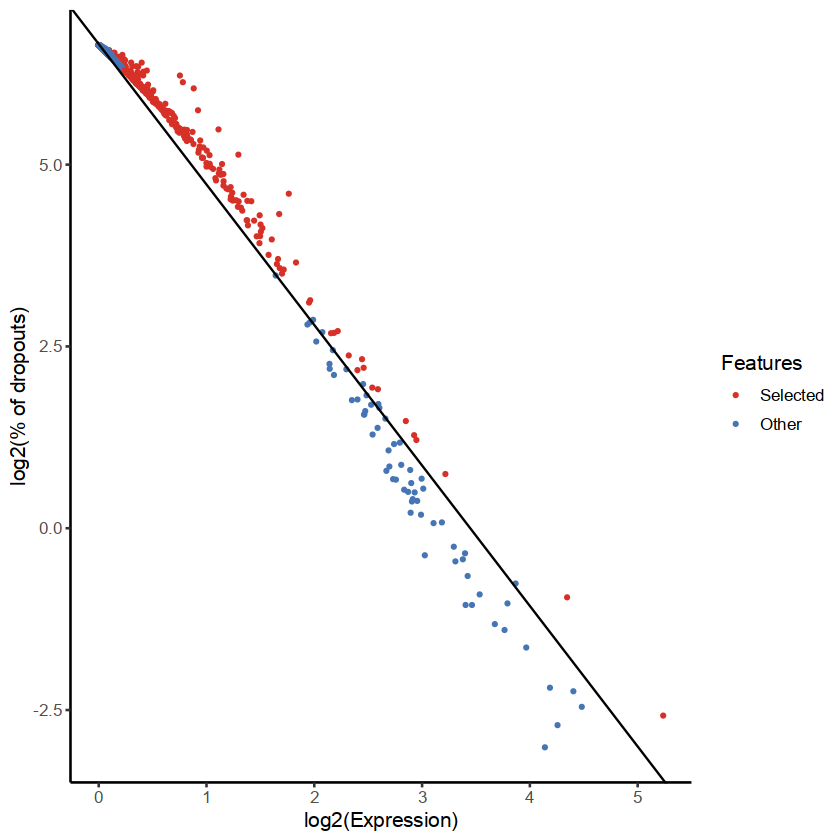

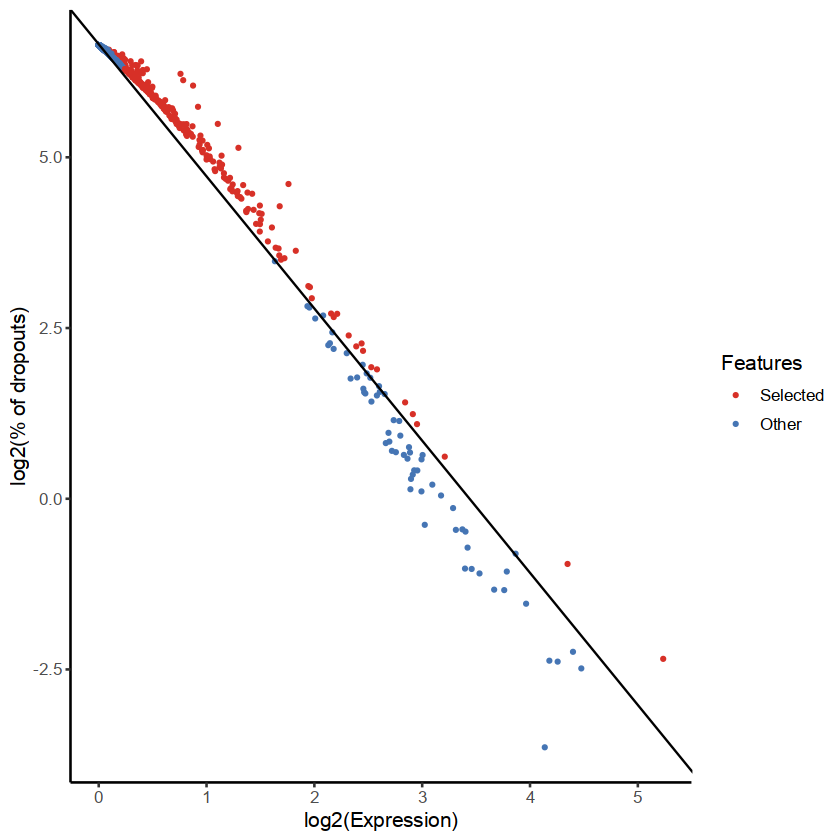

Fold 3 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.2538641 F1 score: 0.370591 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



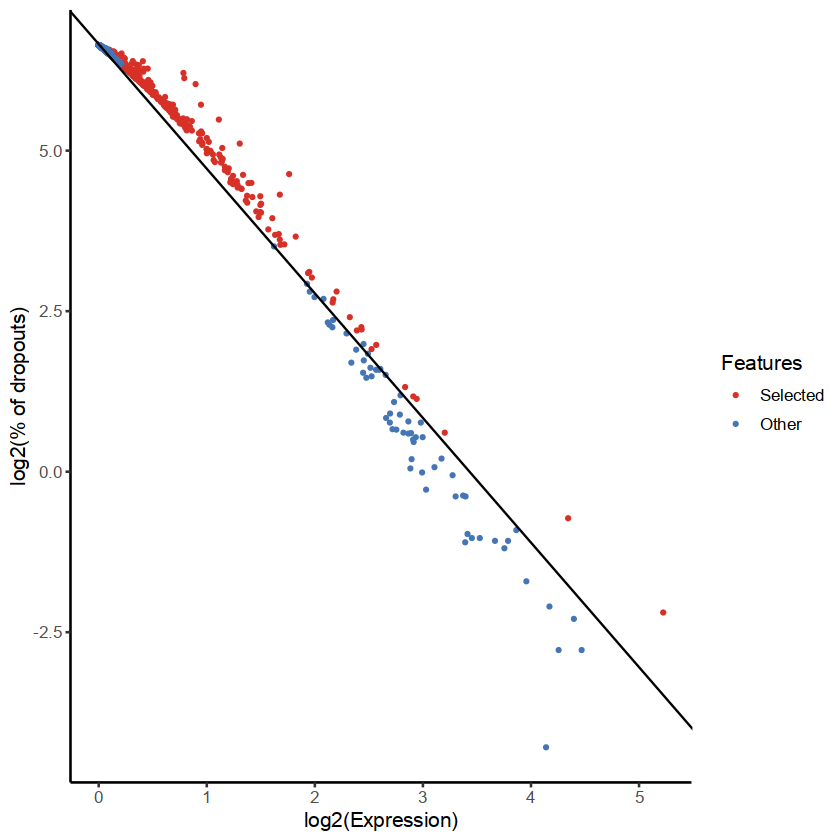

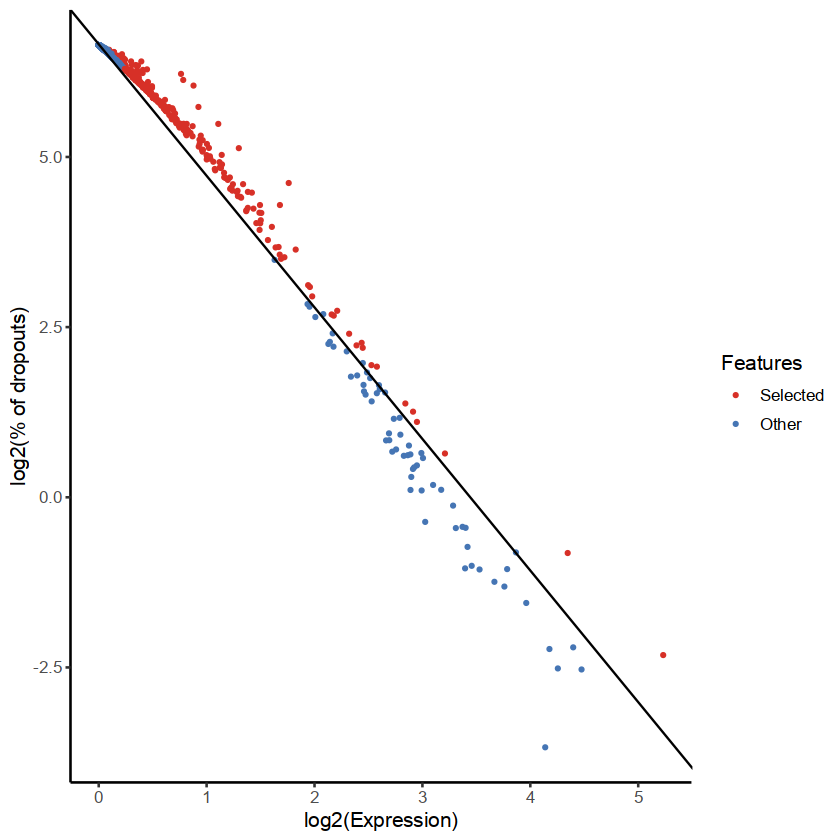

Fold 4 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.2568533 F1 score: 0.4243264 


Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2743200)”


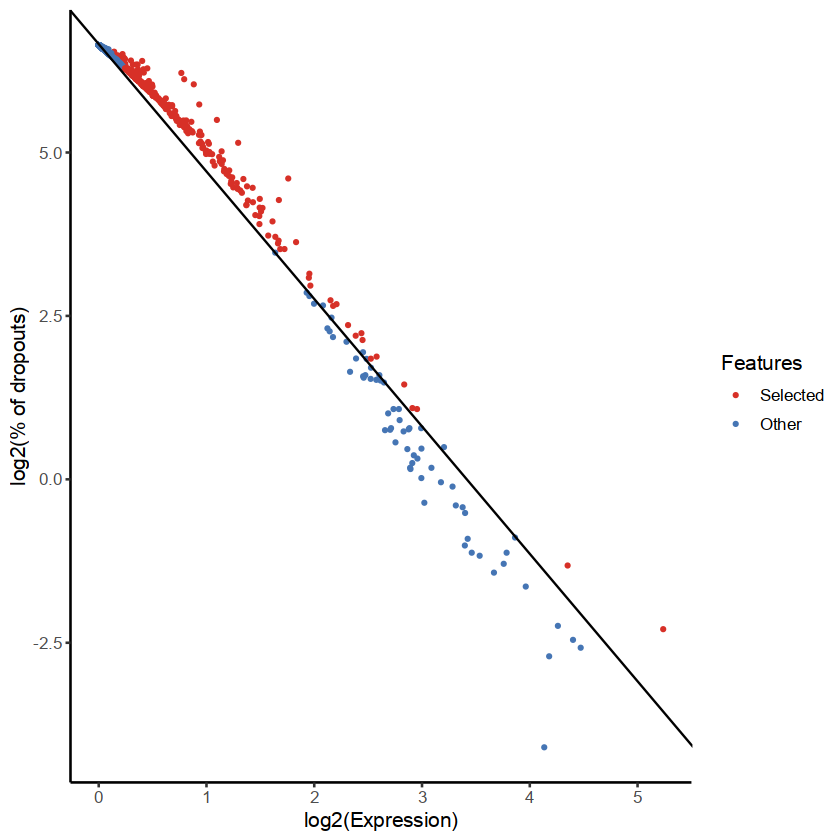

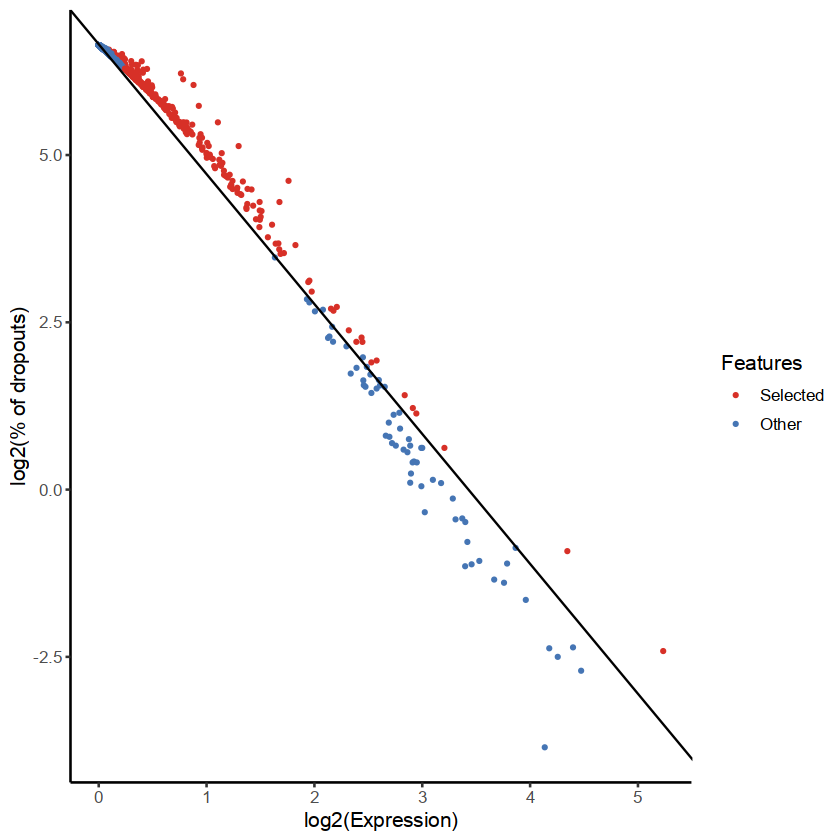

Fold 5 : Train samples = 54864 , Test samples = 13715 Accuracy: 0.250237 F1 score: 0.4200472 


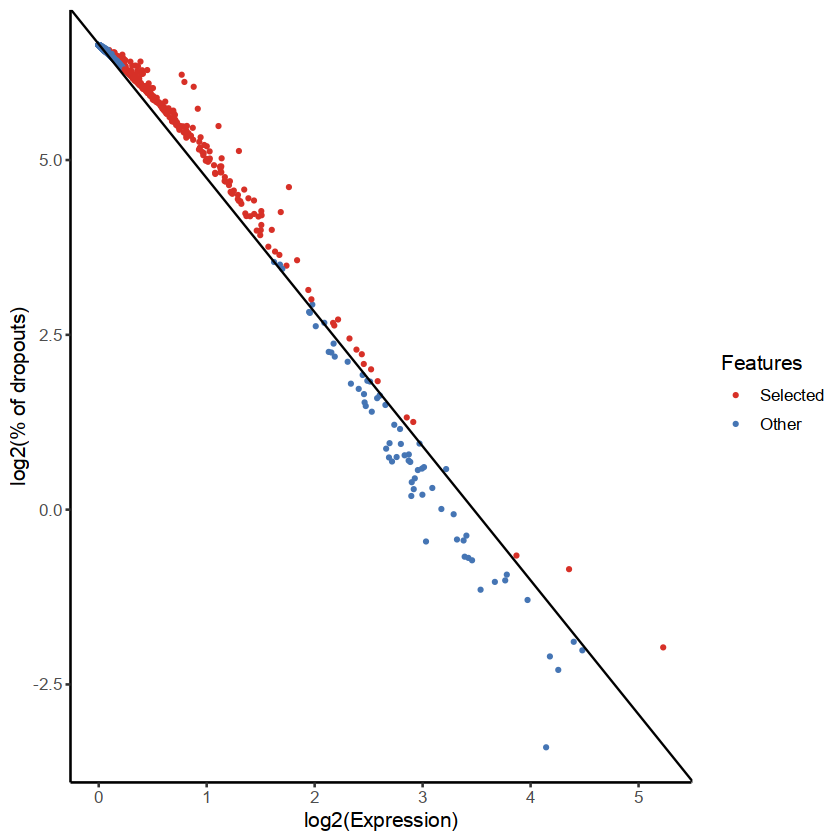

In [5]:
#scmapCell

library(SingleCellExperiment)
library(scmap)  

num_folds <- 5

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]

  anno_train$cell_type1=anno_train$celltype

  reference = SingleCellExperiment(assays = list(counts = t(data_train)),colData = anno_train["cell_type1"])

  logcounts(reference) <- log2(counts(reference) + 1)

  rowData(reference)$feature_symbol <- rownames(reference)
  
  reference <- selectFeatures(reference, suppress_plot = FALSE)

  reference <- indexCell(reference)



  query = SingleCellExperiment(assays = list(counts = t(data_test)))

  logcounts(query) <- log2(counts(query) + 1)

  rowData(query)$feature_symbol <- rownames(query)

  query <- selectFeatures(query, suppress_plot = FALSE)

  #query <- indexCluster(query)



  scmapCell_results <- scmapCell(
  query, 
  index_list = list(
    yan = metadata(reference)$scmap_cell_index
    )
  )

  scmapCell_clusters <- scmapCell2Cluster(
  scmapCell_results, 
  list(
    as.character(colData(reference)$cell_type1)
  )
    )
    predictions=as.vector(scmapCell_clusters$scmap_cluster_labs)

  acc = calculate_test_accuracy(predictions,anno_test$celltype)
  f1_score = calculate_f1_score_multiclass(predictions,anno_test$celltype)

  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "Accuracy:", acc,"F1 score:", f1_score, "\n")

}